In [22]:
import string
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import joblib
# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from source import my_tokenizer

This is the main preprocessing notebook. I will use TF-IDF to vectorise the words, using a custom tokeniser to remove stop words, small inconsietnecies in the text, as well as understanding what words are not in the english language.

In [23]:
nltk.download('wordnet')
nltk.download('words')

[nltk_data] Downloading package wordnet to /Users/edo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /Users/edo/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [56]:
df = pd.read_parquet("../data/clean_technology_reviews_FINAL.parquet")

Dropping duplicated reviews that arise through dropping metadata columns.

In [57]:
df["reviewText"].duplicated().sum()

170769

In [58]:
df = df.drop_duplicates(ignore_index=True, subset="reviewText")

In [59]:
df.head(10)

,overall,reviewText,asin,length
0,5.0,Looks even better in person. Be careful to not...,7508492919,271
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102
2,3.0,"so the case came on time, i love the design. I...",7508492919,257
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150
5,2.0,The product looked exactly like the picture an...,7508492919,159
6,3.0,I FINALLY got my case today. It took forever t...,7508492919,344
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327
8,1.0,DO NOT BUY! this item is seriously cheap as he...,7508492919,190
9,4.0,I really love this case... you have to keep yo...,7508492919,188


In [60]:
pd.DataFrame(np.unique(df['overall'], return_counts=True)).T.set_index(0)

,1
0,
1.0,69133.0
2.0,48552.0
3.0,78994.0
4.0,134058.0
5.0,474075.0


Adding length of reviews to each review

In [61]:
rev_len = list()
for review in df["reviewText"]:
    rev_len.append(len(str(review)))

In [62]:
df["length"] = rev_len

In [63]:
df["length"].describe()

count    804812.000000
mean        247.052354
std         385.543634
min           1.000000
25%          62.000000
50%         136.000000
75%         282.000000
max       33457.000000
Name: length, dtype: float64

In [64]:
shorter = df[df["length"]<=500].copy()


In [65]:
shorter["reviewText"].fillna("", inplace=True)

In [66]:
shorter = shorter.reset_index(drop='index')

In [67]:
shorter["binary"]= np.where(shorter['overall']>3, 1, 0)

In [68]:
shorter.head(10)

,overall,reviewText,asin,length,binary
0,5.0,Looks even better in person. Be careful to not...,7508492919,271,1
1,5.0,When you don't want to spend a whole lot of ca...,7508492919,102,1
2,3.0,"so the case came on time, i love the design. I...",7508492919,257,0
3,2.0,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,7508492919,92,0
4,4.0,"I liked it because it was cute, but the studs ...",7508492919,150,1
5,2.0,The product looked exactly like the picture an...,7508492919,159,0
6,3.0,I FINALLY got my case today. It took forever t...,7508492919,344,0
7,5.0,It is a very cute case. None of the jewels hav...,7508492919,327,1
8,1.0,DO NOT BUY! this item is seriously cheap as he...,7508492919,190,0
9,4.0,I really love this case... you have to keep yo...,7508492919,188,1


In [69]:
shorter.isna().sum()

overall       0
reviewText    0
asin          0
length        0
binary        0
dtype: int64

In [70]:
shorter.duplicated(subset="reviewText").sum()

0

Vectorising based on just a train split

In [71]:
X_1 = shorter["reviewText"].copy()
y_1= shorter["binary"]

# 
X_rem, X_test, y_rem, y_test = train_test_split(X_1, y_1, test_size=0.2, stratify=y_1,random_state=42)

In [72]:
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.2,stratify=y_rem, random_state=42)

In [73]:
stop_words = stopwords.words('english')

Using a custom tokenizer, we can strip out bits of reviews that do not provide signal, like short bits of text or stop words. I use the nltk stop words. I will probably return and use a custom stop word list, the my_tokenizer can be found in the source file

Fitting the vectoriser on the reviews, for now 500 features, maybe will need to address this. Also using 1 and 2 grams

In [74]:
# 1 grams
tfidf = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=500)
tfidf.fit(X_train)
X_train_transformed = tfidf.transform(X_train)
X_val_transformed = tfidf.transform(X_val)

/Users/edo/anaconda3/envs/es_capstone/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [75]:
# 2_grams
tfidf_2grams = TfidfVectorizer(min_df=10,tokenizer = my_tokenizer, max_features=100, ngram_range=(2,2))
tfidf_2grams.fit(X_train)
X_train_transformed_2grams = tfidf_2grams.transform(X_train)
X_val_transformed_2grams = tfidf_2grams.transform(X_val)

In [76]:
word_counts = pd.DataFrame(
    {"counts": X_train_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names_out()
).sort_values("counts", ascending=False)

In [77]:
word_counts_2grams = pd.DataFrame(
    {"counts": X_train_transformed_2grams.toarray().sum(axis=0)},
    index=tfidf_2grams.get_feature_names_out()
).sort_values("counts", ascending=False)

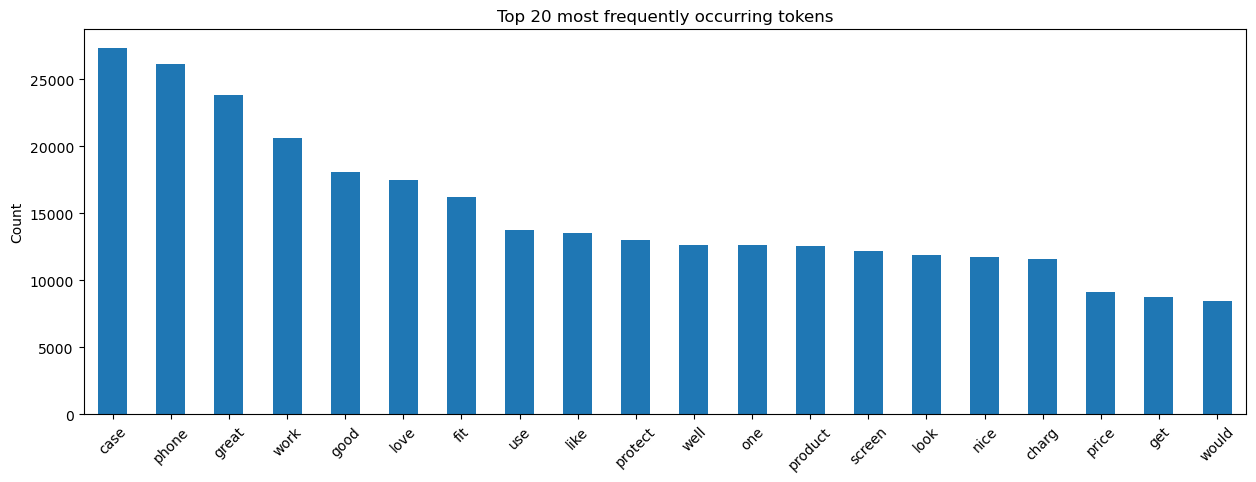

In [78]:
# frequency of 1-grams, most reviews are positive  
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring tokens")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [79]:
word_counts

,counts
case,27350.042655
phone,26149.985700
great,23819.686867
work,20604.921999
good,18111.554907
...,...
posit,716.657218
wall,712.974026
happen,698.329227
contact,684.649180


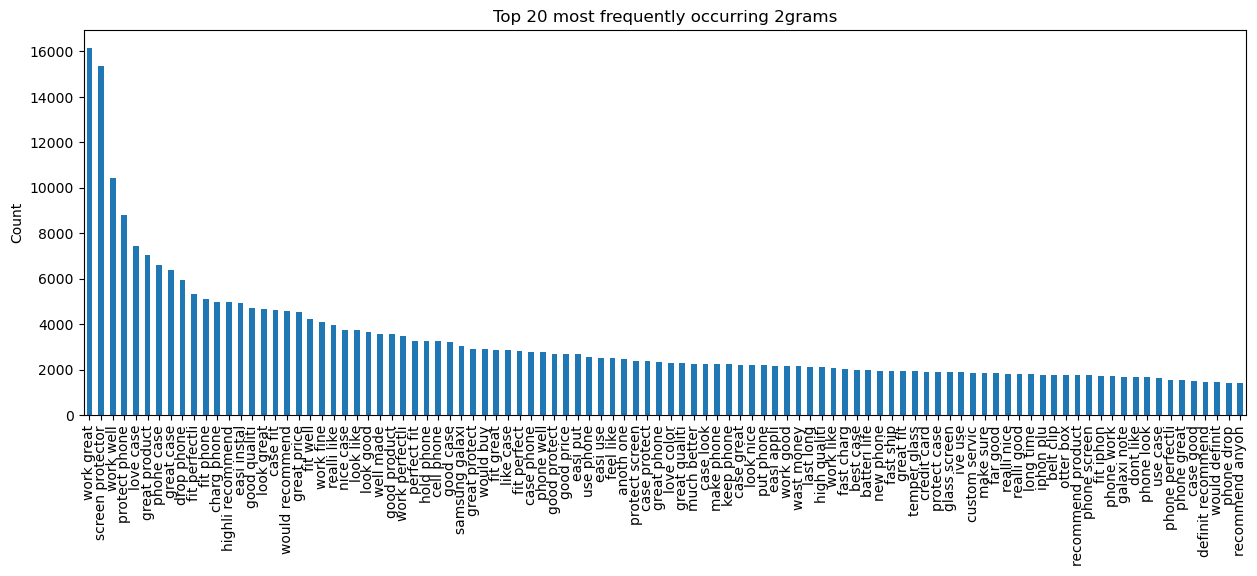

In [80]:
word_counts_2grams.plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring 2grams")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [81]:
word_counts_2grams.head()

,counts
work great,16127.105688
screen protector,15360.862199
work well,10423.300250
protect phone,8783.094990
love case,7415.587091


Let's understand the word counts for single tokens in terms of spelling error

In [82]:
feat = tfidf.get_feature_names_out()

In [83]:
english_words = set(nltk.corpus.words.words())

stemmed_english_list = []
for i in english_words:
    token = PorterStemmer().stem(i)
    stemmed_english_list.append(token)


In [84]:
len(stemmed_english_list)

235892

In [85]:
total_word_counts = pd.concat([word_counts, word_counts_2grams], axis=0).sort_values("counts", ascending=False)
total_word_counts

,counts
case,27350.042655
phone,26149.985700
great,23819.686867
work,20604.921999
good,18111.554907
...,...
posit,716.657218
wall,712.974026
happen,698.329227
contact,684.649180


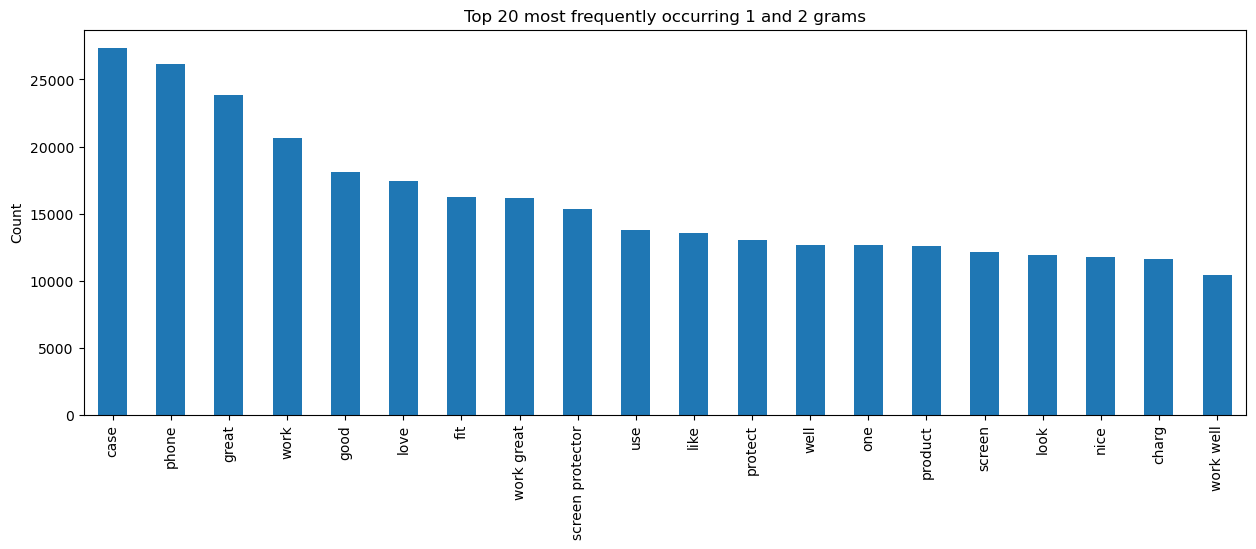

In [86]:
total_word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title("Top 20 most frequently occurring 1 and 2 grams")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [87]:
joblib.dump(total_word_counts, "../data/total_word_freq.pkl")

['../data/total_word_freq.pkl']

Here we can see 16% of tokens not recognised in stemmed english language.

In [88]:
unrecognized_tokens = [token for token in feat if token.lower() not in stemmed_english_list]
num_unrec = len(unrecognized_tokens)
num_unrec/len(feat)

0.048

In [89]:
unrecognized_word_counts = word_counts[word_counts.index.isin(unrecognized_tokens)]
print(f"Unrecognised words: {len(unrecognized_word_counts)}")
unrecognized_word_counts.sort_values(by = 'counts', ascending=False).head(5)

Unrecognised words: 24


,counts
iphon,7213.375402
ive,4245.777675
im,4105.813241
samsung,3310.230330
otterbox,2325.956225


In [90]:
unrecognized_word_counts.describe()

,counts
count,24.000000
mean,1786.972281
std,1517.024223
min,782.644774
25%,1001.402272
50%,1116.376983
75%,1606.616657
max,7213.375402


In [91]:
unrecognized_word_counts.quantile(0.99)

counts    6530.827925
Name: 0.99, dtype: float64

In [92]:
unrecognized_word_counts.head(10)

,counts
iphon,7213.375402
ive,4245.777675
im,4105.813241
samsung,3310.230330
otterbox,2325.956225
usb,2140.309405
isnt,1428.719074
s5,1373.083417
ipad,1300.922717
lg,1269.048643


Here we can get the vectorised versions of the reviews boths as 1-grams and 2-grams:

In [93]:
# 1-grams vec
review_vectors = tfidf.transform(shorter["reviewText"].fillna(''))


In [94]:
# to a dataframe
review_vectors_df = pd.DataFrame(review_vectors.toarray(), columns=tfidf.get_feature_names_out())


In [95]:
# 2-grams vec
review_vectors_2grams = tfidf_2grams.transform(shorter["reviewText"].fillna(''))


In [96]:
# to a dataframe
review_vectors_df_2grams = pd.DataFrame(review_vectors_2grams.toarray(), columns=tfidf_2grams.get_feature_names_out())


In [97]:
output_df_1_2 = pd.concat([shorter, review_vectors_df, review_vectors_df_2grams], axis=1)


In [98]:
output_df_1_2.to_pickle("../data/reviews_vector_1_and_2grams.pkl")

In [99]:
# # merge with reviews
# output_df = pd.concat([shorter, review_vectors_df], axis=1)
# # merge with reviews
# output_df_2grams = pd.concat([shorter, review_vectors_df_2grams], axis=1)
# # pickle 1xgrams
# output_df.to_pickle("../data/reviews_vector_1grams.pkl")
# # pickle 2grams
# output_df_2grams.to_pickle("../data/reviews_vector_2grams.pkl")